In [1]:
import os
import netCDF4 as nc
import numpy as np
import pandas as pd
from scipy.io import loadmat 
import scipy.stats as stats
from datetime import datetime

import matplotlib.ticker as ticker
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.transforms as transform
import matplotlib.cm as cm
%matplotlib inline
import cmocean
import plotting
from takeout import monthly_means_annual, monthly_std_annual

import copy

In [2]:
# constant declarations
#lat1 < lat2
lat1 = -20
lat2 = 20

lat_lims = [lat1,lat2]

#assuming all years are independent
yrmax = 39
monmax = 468
critical_t = stats.t.ppf(q=0.975, df=monmax)

#variable files on disk
nino_file = '/home/jakidxav/Desktop/work_hartmann/nino_data/Nino_3-4.mat'
omega_file = '/home/jakidxav/Desktop/work_hartmann/erai_monthly/mergeFiles/w_7917.nc'

jan,feb,mar,apr,may,jun,jul,aug,sep,octo,nov,dec = [],[],[],[],[],[],[],[],[],[],[],[]

mon_list = [jan, feb, mar, apr, may, jun, jul, aug, sep, octo, nov, dec]

corr3_max, corr34_max, corr4_max = [], [], []
reg3_max, reg34_max, reg4_max = [], [], []

lon_list = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 239]

#lon_list_labels = ["180W", "150W", "120W", "90W", "60W", "30W", "0", "30E", "60E", "90E", "120E", "150E", "180E"]
lon_list_labels = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 358.5]

shifted_lon_list = [60, 80, 100, 120, 140, 160, 180, 200, 220, 239, 0, 20, 40]
shifted_lon_list_labels = [90, 120, 150, 180, 210, 240, 270, 300, 330, 358.5, 0, 30, 60]
shifted_labels_eastWest = ['90E', '120E', '150E', '180', '150W', '120W', '90W', '60W', '30W', '0', '30E', '60E', '90E']

#ytick_list = [36, 25, 21, 17, 14, 10, 9]
p_tick_list = [0, 1, 5, 8, 12, 16, 28]
p_list = [70, 100, 200, 300, 500, 700, 1000]
z_list = [5, 10, 15, 20, 25]

#for plotting
vmin = -0.46
vmax = 0.51
contours = np.arange(vmin, vmax, 0.05)

colormap = cmocean.cm.balance
colorbar_label = r"$hPa \hspace{1} s^{-1}$"

left_title = '$\omega$ '
left_title_down = '-$\omega$ '
nino3_title = 'Niño 3 '
nino34_title = 'Niño 3.4 '
nino4_title = 'Niño 4 '
corr_title = 'Correlation, max='
reg_title = 'Regression, max='

#It is actually omega, but weighted for regions where it is upward(or negative) between x˚S and x˚N.
right_title = '1979-2017'

#axis labels
p_label = 'Pressure (mb)'
z_label = 'Height (km)'

figure_name_corr3_up = 'lon_omegaCorr_up_Nino3_'+str(lat_lims[0])+'_'+str(lat_lims[1])+'_AllYears.pdf'
figure_name_corr34_up = 'lon_omegaCorr_up_Nino34_'+str(lat_lims[0])+'_'+str(lat_lims[1])+'_AllYears.pdf'
figure_name_corr4_up = 'lon_omegaCorr_up_Nino4_'+str(lat_lims[0])+'_'+str(lat_lims[1])+'_AllYears.pdf'

figure_name_corr3_down = 'lon_omegaCorr_down_Nino3_'+str(lat_lims[0])+'_'+str(lat_lims[1])+'_AllYears.pdf'
figure_name_corr34_down = 'lon_omegaCorr_down_Nino34_'+str(lat_lims[0])+'_'+str(lat_lims[1])+'_AllYears.pdf'
figure_name_corr4_down = 'lon_omegaCorr_down_Nino4_'+str(lat_lims[0])+'_'+str(lat_lims[1])+'_AllYears.pdf'

figure_name_reg3_up = 'lon_omegaReg_up_Nino3_'+str(lat_lims[0])+'_'+str(lat_lims[1])+'_AllYears.pdf'
figure_name_reg34_up = 'lon_omegaReg_up_Nino34_'+str(lat_lims[0])+'_'+str(lat_lims[1])+'_'+'_AllYears.pdf'
figure_name_reg4_up = 'lon_omegaReg_up_Nino4_'+str(lat_lims[0])+'_'+str(lat_lims[1])+'_AllYears.pdf'

figure_name_reg3_down = 'lon_omegaReg_down_Nino3_'+str(lat_lims[0])+'_'+str(lat_lims[1])+'_AllYears.pdf'
figure_name_reg34_down = 'lon_omegaReg_down_Nino34_'+str(lat_lims[0])+'_'+str(lat_lims[1])+'_AllYears.pdf'
figure_name_reg4_down = 'lon_omegaReg_down_Nino4_'+str(lat_lims[0])+'_'+str(lat_lims[1])+'_AllYears.pdf'

# Data Import

In [3]:
#read in data files
#omega is in hPa NOT Pa
omega_data = nc.Dataset(omega_file)

#process variables
omega = omega_data.variables['w'][:]

lon  = omega_data.variables['longitude'][:]
lat  = omega_data.variables['latitude'][:]
dumb_time = omega_data.variables['time'][:]
p = omega_data.variables['level'][:]

#convert time to more user-friendly format
time = pd.to_datetime(dumb_time, unit='h',
                       origin=pd.Timestamp('1900-01-01'))

#for boolean indexing
latidx = (lat >=lat_lims[0] ) & (lat <=lat_lims[1] )

#only take pressures greater than 10hPa (for plotting purposes)
pidx = p >= 70

#subset new tensors for correct latitude, pressure ranges
omega = omega[:, :, latidx, :]
omega = omega[:, pidx, :, :]

#w: FillValue = -32767.
omega = omega.filled(np.nan)

In [4]:
#create monthly means for normalization
monthly_means = monthly_means_annual(omega, time)

#create monthly std for standardization
monthly_std = monthly_std_annual(omega, time)

#normalize omega data, subtract monthly means
count = 1
for i in np.arange(1979, 2018):
    for j in np.arange(1, 13):
        month = time[count-1].month - 1
        omega[count-1] = omega[count-1] - monthly_means[month]
        count = count + 1
        
#standardize omega data, divide by monthly stds
omega_std = copy.deepcopy(omega)

count2 = 1
for i in np.arange(1979, 2018):
    for j in np.arange(1, 13):
        month = time[count2-1].month -1
        omega_std[count2-1] = np.divide(omega_std[count2-1], monthly_std[month])
        count2 = count2 + 1

In [5]:
print(omega.shape)

(468, 28, 27, 240)


### Start Mask Here

1. Make sure to normalize and standardize omega
    -if having memory problems, do normalization first for regression only

2. Need to process up and down masks separately, but not dividing by area at the end.

3. Read in Nino Indices

4. Do **ANNUAL** plots first. So no need for for loop yet.

In [6]:
#copy array for creating mask
mask_up = copy.deepcopy(omega_std)
mask_down = copy.deepcopy(omega_std)
#mask_total = copy.deepcopy(omega)

#upward mask: M_up
mask_up[np.where(mask_up > 0)] = np.nan
mask_up[np.where(mask_up < 0)] = 1

#downward mask: M_down
mask_down[np.where(mask_down > 0)] = 1
mask_down[np.where(mask_down < 0)] = np.nan

#MX
mask_var_up = np.multiply(omega_std, mask_up)
mask_var_down = np.multiply(omega_std, mask_down)

/home/jakidxav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


In [7]:
#create cos(lat) matrix
cos_lat = np.asmatrix(np.cos(np.deg2rad(lat[latidx]))).T
cos_lat_matrix = np.multiply(np.ones((27,240)), cos_lat)
#plt.pcolormesh(np.array(cos_lat_matrix))

#MXcos(lat) = AX
mask_var_coslat_up = np.multiply(mask_var_up, np.array(cos_lat_matrix))
mask_var_coslat_down = np.multiply(mask_var_down, np.array(cos_lat_matrix))

#A_up, A_down
mask_up_coslat = np.multiply(mask_up, np.array(cos_lat_matrix))
mask_down_coslat = np.multiply(mask_down, np.array(cos_lat_matrix))

In [8]:
#integrate (sum) over latitude, leaves lon-height time series
mask_var_nanmean_up = np.nanmean(mask_var_coslat_up, axis=2)
mask_var_nanmean_down = np.nanmean(mask_var_coslat_down, axis=2)

mask_nanmean_up = np.nanmean(mask_up_coslat, axis=2)
mask_nanmean_down = np.nanmean(mask_down_coslat, axis=2)

/home/jakidxav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/home/jakidxav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jakidxav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/home/jakidxav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


In [10]:
#divide by total area
total_up = np.divide(mask_var_nanmean_up, mask_nanmean_up)
total_down = np.divide(mask_var_nanmean_down, mask_nanmean_down)

In [11]:
missing_up = np.count_nonzero(np.isnan(total_up))
missing_down = np.count_nonzero(np.isnan(total_down))
total = 468 * 28 * 240
missing = missing_up / total * 100
print('The amount of missing data after processing is '+str(np.round(missing, 3))+'%.')

The amount of missing data after processing is 0.28%.


In [12]:
# Need to replace these values with 0 before doing regression
total_up[np.where(np.isnan(total_up))] = 0
total_down[np.where(np.isnan(total_down))] = 0

### Estimate DOF

In [14]:
#autocorrelation of omega for one time lag
aa = np.matmul(np.reshape(total_up[:-1], (467, -1)), np.reshape(total_up[:-1], (467, -1)).T) / (monmax - 1)
ab = np.matmul(np.reshape(total_up[1:], (467, -1)), np.reshape(total_up[1:], (467, -1)).T) / (monmax - 1)
ac = np.divide(ab, aa)
autt = np.nanmean(np.multiply(ac, aa)) / np.nanmean(aa)
dof = (monmax - 1) * (1 - autt*autt) / (1 + autt*autt)

In [15]:
dof

0.01397908115383616

## Read in Indices for regression, correlation maps

In [16]:
nino_data = loadmat(nino_file)

keep = ['anom34', 'nino3', 'nino34', 'nino4', 'year']
sub_nino = dict((k, nino_data[k]) for k in keep if k in nino_data)

columns = ['anom34', 'nino3', 'nino34', 'nino4', 'year']
anom34_ = sub_nino['anom34'].flatten()
nino3_  = sub_nino['nino3'].flatten()
nino34_ = sub_nino['nino34'].flatten()
nino4_  = sub_nino['nino4'].flatten()
year   = sub_nino['year'].flatten()

corrected_year = list(year)
corrected_year.insert(0, 1950.000000)
del corrected_year[-1]

#create nino dataframe with all years
nino_full = pd.DataFrame({'anom34':anom34_, 'nino3':nino3_, 'nino34':nino34_,
                    'nino4':nino4_, 'year':corrected_year})

#create subset of nino dataframe, 1950 <= years <= 2017
nino_full.set_index('year')
nino_full['month'] = nino_full.year % 1 * 12 + 1
nino_full.year = nino_full.year.astype(int)
nino = nino_full[nino_full.year<2018]

#standardized nino indices dataframe, not including years/months as columns
nino_std = pd.DataFrame()
nino_std['month'] = nino.month
nino_std['year'] = nino.year

In [43]:
#nino_std['nino3'] = (nino.nino3 - nino.nino3.mean()) / nino.nino3.std()
#nino_std['nino34'] = (nino.nino34 - nino.nino34.mean()) / nino.nino34.std()
#nino_std['nino4'] = (nino.nino4 - nino.nino4.mean()) / nino.nino4.std()

#calculate monthly means and standard deviations for nino indices
#make empty columns for standardized indices
nino3_month_means = np.array(nino.nino3.groupby(nino.month).mean())
nino3_month_std = np.array(nino.nino3.groupby(nino.month).std())
nino_std['nino3'] = np.nan

nino34_month_means = np.array(nino.nino34.groupby(nino.month).mean())
nino34_month_std = np.array(nino.nino34.groupby(nino.month).std())
nino_std['nino34'] = np.nan

nino4_month_means = np.array(nino.nino4.groupby(nino.month).mean())
nino4_month_std = np.array(nino.nino4.groupby(nino.month).std())
nino_std['nino4'] = np.nan

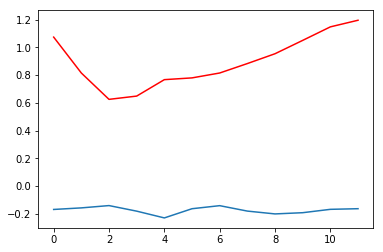

In [44]:
plt.plot(nino3_month_std, color='r')
plt.plot(nino3_month_means)

In [45]:
nino_std.head()

,month,year,nino3,nino34,nino4
0,1.0,1950,NaN,NaN,NaN
1,2.0,1950,NaN,NaN,NaN
2,3.0,1950,NaN,NaN,NaN
3,4.0,1950,NaN,NaN,NaN
4,5.0,1950,NaN,NaN,NaN


In [57]:
#remove monthly means
counter = 1
for i in np.arange(1950, 2018):
    for j in np.arange(1, 13):
        month = np.round(nino_std.month[counter] - 1)
        #nino_std.nino3[counter - 1] = nino.nino3[counter - 1] - nino3_month_means[month]
        #nino_std.nino34[counter - 1] = nino.nino34[counter - 1] - nino34_month_means[month]
        #nino_std.nino4[counter - 1] = nino.nino4[counter - 1] - nino4_month_means[month]
        print(i, j, month)
        counter = counter + 1

#divide by standard deviations

1950 1 1.0
1950 2 2.0
1950 3 3.0
1950 4 4.0
1950 5 5.0
1950 6 6.0
1950 7 7.0
1950 8 8.0
1950 9 9.0
1950 10 10.0
1950 11 11.0
1950 12 0.0
1951 1 1.0
1951 2 2.0
1951 3 3.0
1951 4 4.0
1951 5 5.0
1951 6 6.0
1951 7 7.0
1951 8 8.0
1951 9 9.0
1951 10 10.0
1951 11 11.0
1951 12 0.0
1952 1 1.0
1952 2 2.0
1952 3 3.0
1952 4 4.0
1952 5 5.0
1952 6 6.0
1952 7 7.0
1952 8 8.0
1952 9 9.0
1952 10 10.0
1952 11 11.0
1952 12 0.0
1953 1 1.0
1953 2 2.0
1953 3 3.0
1953 4 4.0
1953 5 5.0
1953 6 6.0
1953 7 7.0
1953 8 8.0
1953 9 9.0
1953 10 10.0
1953 11 11.0
1953 12 0.0
1954 1 1.0
1954 2 2.0
1954 3 3.0
1954 4 4.0
1954 5 5.0
1954 6 6.0
1954 7 7.0
1954 8 8.0
1954 9 9.0
1954 10 10.0
1954 11 11.0
1954 12 0.0
1955 1 1.0
1955 2 2.0
1955 3 3.0
1955 4 4.0
1955 5 5.0
1955 6 6.0
1955 7 7.0
1955 8 8.0
1955 9 9.0
1955 10 10.0
1955 11 11.0
1955 12 0.0
1956 1 1.0
1956 2 2.0
1956 3 3.0
1956 4 4.0
1956 5 5.0
1956 6 6.0
1956 7 7.0
1956 8 8.0
1956 9 9.0
1956 10 10.0
1956 11 11.0
1956 12 0.0
1957 1 1.0
1957 2 2.0
1957 3 3.0
1957 4 4

2013 7 7.0
2013 8 8.0
2013 9 9.0
2013 10 10.0
2013 11 11.0
2013 12 0.0
2014 1 1.0
2014 2 2.0
2014 3 3.0
2014 4 4.0
2014 5 5.0
2014 6 6.0
2014 7 7.0
2014 8 8.0
2014 9 9.0
2014 10 10.0
2014 11 11.0
2014 12 0.0
2015 1 1.0
2015 2 2.0
2015 3 3.0
2015 4 4.0
2015 5 5.0
2015 6 6.0
2015 7 7.0
2015 8 8.0
2015 9 9.0
2015 10 10.0
2015 11 11.0
2015 12 0.0
2016 1 1.0
2016 2 2.0
2016 3 3.0
2016 4 4.0
2016 5 5.0
2016 6 6.0
2016 7 7.0
2016 8 8.0
2016 9 9.0
2016 10 10.0
2016 11 11.0
2016 12 0.0
2017 1 1.0
2017 2 2.0
2017 3 3.0
2017 4 4.0
2017 5 5.0
2017 6 6.0
2017 7 7.0
2017 8 8.0
2017 9 9.0
2017 10 10.0
2017 11 11.0


KeyError: 816

In [ ]:
nino_std.head()

In [ ]:
#starter list for following loop
jan = mon_list[0]
january = nino[nino.month==1]
jan.append(january.index.values)
jan = np.array(jan)

#read in monthly indices for later traversal
#note: these have shape (1, yrmx), so need to use np.squeeze() later
for i in np.arange(1, 12):
    last_month = np.squeeze(mon_list[i-1])
    month = np.add(last_month, 1)
    mon_list[i].append(month)

nino_std = nino_std[nino.year > 1978]

nino3 = nino_std.nino3
nino34 = nino_std.nino34
nino4 = nino_std.nino4

In [17]:
nino_std.head()

,month,year,nino3,nino34,nino4
348,1.0,1979,-0.171688,-0.012716,0.398460
349,2.0,1979,-0.127660,-0.092359,0.206809
350,3.0,1979,0.180537,0.180702,0.368975
351,4.0,1979,0.378663,0.294477,0.442687
352,5.0,1979,0.246579,0.010039,0.206809


## Regression, Correlation

In [18]:
reshape_up = np.reshape(total_up, (468, -1))
reshape_down = np.reshape(total_down, (468, -1))

In [20]:
#correlation maps
#to change from up and down omega mask, need to change reshape_up/down, nanmin/max
corr3 = np.matmul(nino3, reshape_up) / monmax
corr34 = np.matmul(nino34, reshape_up) / monmax
corr4 = np.matmul(nino4, reshape_up) / monmax
    
corr3_max.append(np.round(np.nanmin(corr3), 5))
corr34_max.append(np.round(np.nanmin(corr34), 5))
corr4_max.append(np.round(np.nanmin(corr4), 5))
    
t3 = corr3 * np.sqrt(dof - 2) / np.sqrt(1 - corr3**2)
t34 = corr34 * np.sqrt(dof - 2) / np.sqrt(1 - corr34**2)
t4 = corr4 * np.sqrt(dof - 2) / np.sqrt(1 - corr4**2)
    

#regression maps
#reg3 = np.matmul(nino3, reshape) / monmax
#reg34 = np.matmul(nino34, reshape) / monmax
#reg4 = np.matmul(nino4, reshape) / monmax
    
#reg3_max.append(np.round(np.nanmax(reg3), 5))
#reg34_max.append(np.round(np.nanmax(reg34), 5))
#reg4_max.append(np.round(np.nanmax(reg4), 5))

/home/jakidxav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()
/home/jakidxav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':
/home/jakidxav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]


In [21]:
#reshape corr and reg arrays for plotting
corr3_reshape = np.reshape(corr3, (28, 240))
corr34_reshape = np.reshape(corr34, (28, 240))
corr4_reshape = np.reshape(corr4, (28, 240))

t3_reshape = np.reshape(t3, (28, 240))
t34_reshape = np.reshape(t34, (28, 240))
t4_reshape = np.reshape(t4, (28, 240))

In [22]:
#shift array to have Tropics in the middle
zeros = np.zeros((28, 240))
zeros[:, 0:120] = corr3_reshape[:, 60:180]
zeros[:, 120:180] = corr3_reshape[:, 180:240]
zeros[:, 180:240] = corr3_reshape[:, 0:60]

tstat = np.zeros((28, 240))
tstat[:, 0:120] = t3_reshape[:, 60:180]
tstat[:, 120:180] = t3_reshape[:, 180:240]
tstat[:, 180:240] = t3_reshape[:, 0:60]

zeros2 = np.zeros((28, 240))
zeros2[:, 0:120] = corr34_reshape[:, 60:180]
zeros2[:, 120:180] = corr34_reshape[:, 180:240]
zeros2[:, 180:240] = corr34_reshape[:, 0:60]

tstat2 = np.zeros((28, 240))
tstat2[:, 0:120] = t34_reshape[:, 60:180]
tstat2[:, 120:180] = t34_reshape[:, 180:240]
tstat2[:, 180:240] = t34_reshape[:, 0:60]

zeros3 = np.zeros((28, 240))
zeros3[:, 0:120] = corr4_reshape[:, 60:180]
zeros3[:, 120:180] = corr4_reshape[:, 180:240]
zeros3[:, 180:240] = corr4_reshape[:, 0:60]

tstat3 = np.zeros((28, 240))
tstat3[:, 0:120] = t4_reshape[:, 60:180]
tstat3[:, 120:180] = t4_reshape[:, 180:240]
tstat3[:, 180:240] = t4_reshape[:, 0:60]

print(np.nanmax(zeros))
print(np.nanmin(zeros))
print(np.nanmax(zeros2))
print(np.nanmin(zeros2))
print(np.nanmax(zeros3))
print(np.nanmin(zeros3))

-0.0282859020029559
-0.45533744406580934
0.0045894132710980464
-0.3900447998239684
-0.07945455647629324
-0.38558655114711826


# $\omega$ Map

In [23]:
def plot_contours_latHeight_corrReg(vmin, vmax, field, contours, cmap, cbar_label, left, nino, extra, right, 
                            t, minmax, p_list, p_label, lon_list, lon_labels, p_tick_list, z_label, figname, savefig):
    #fig = plt.figure(figsize=(300, 75))
    fig, ax = plt.subplots()

    Norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    contourf = plt.contourf(field, contours, cmap=cmap, norm=Norm)
    plt.contour(t > critical_t, colors='black')
    plt.contour(t < -critical_t, colors='black')

    cbar = fig.colorbar(contourf, orientation='horizontal')
    cbar.set_label(cbar_label)
    plt.gca().invert_yaxis()

    ax.set_title(left+nino+extra+str(minmax[0]), loc='left', weight='semibold', size='medium')
    ax.set_title(right, loc='right', weight='semibold', size='medium')
    ax.set_ylabel(p_label)

    ax.set_xticks(lon_list)
    ax.set_xticklabels(lon_labels)
    ax.set_yticks(p_tick_list)
    ax.set_yticklabels(p_list, fontsize=6)

    ax2 = ax.twinx()
    ax2.set_ylim(20, 0)
    ax2.set_ylabel(z_label)

    plt.gca().invert_yaxis()

    #plt.tight_layout()
    if (savefig == True):
        plt.savefig(figname, format='pdf')
    
    plt.tight_layout()
    plt.show()

/home/jakidxav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/home/jakidxav/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/jakidxav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


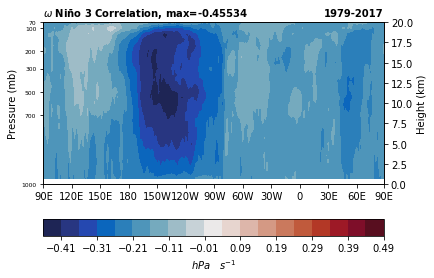

In [24]:
#to change from up and down omega plots, need to change: left title, figure name
plot_contours_latHeight_corrReg(vmin, vmax, zeros, contours, colormap, colorbar_label, left_title, nino3_title, corr_title, right_title, 
                        tstat, corr3_max, p_list, p_label, lon_list, shifted_labels_eastWest, p_tick_list, z_label, figure_name_corr3_up, False)

/home/jakidxav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/home/jakidxav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


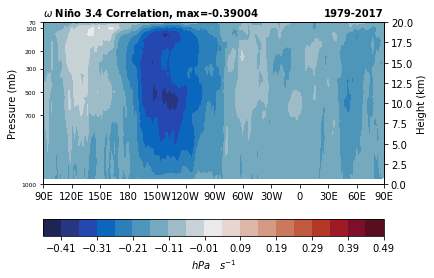

In [25]:
plot_contours_latHeight_corrReg(vmin, vmax, zeros2, contours, colormap, colorbar_label, left_title, nino34_title, corr_title, right_title, 
                        tstat2, corr34_max, p_list, p_label, lon_list, shifted_labels_eastWest, p_tick_list, z_label, figure_name_corr34_up, False)

/home/jakidxav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/home/jakidxav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


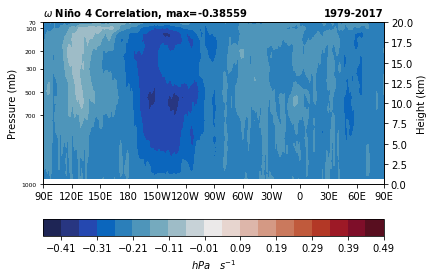

In [26]:
plot_contours_latHeight_corrReg(vmin, vmax, zeros3, contours, colormap, colorbar_label, left_title, nino4_title, corr_title, right_title, 
                        tstat3, corr4_max, p_list, p_label, lon_list, shifted_labels_eastWest, p_tick_list, z_label, figure_name_corr4_up, False)